This notebook is part of the SelfiSys project and is licensed under the GNU General Public License v3.0 or later (GPL-3.0-or-later). See the accompanying LICENSE file or visit [GNU GPL](https://www.gnu.org/licenses/gpl-3.0.en.html) for details.

Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Survey mask

Generate a survey mask from an external sky map.

## Set up the environment and parameters

In [1]:
from selfisys.global_parameters import *

plotly = False
wd = Path(OUTPUT_PATH) / "expl_notebooks/surveymask/"

In [2]:
from os.path import exists
from datetime import datetime
import warnings

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from matplotlib import colormaps
from matplotlib.colors import LinearSegmentedColormap, rgb2hex

# Project-specific imports
from selfisys.utils.plot_params import *  # Plotting configuration
from selfisys.utils.plot_utils import *  # Utility functions for plotting
if plotly:
    from selfisys.utils.examples_utils import clear_large_plot

# Use today's date string for labelling outputs
today = datetime.today().strftime("%b%d")
output_dir = Path(wd) / "expl"
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Load the base map
hpx = hp.read_map(Path(OUTPUT_PATH) / "DATA/external_map.fits")

## Generate the 3D survey mask

In [4]:
N = 64  # Number of grid points
L = 3.6  # Box size (in Gpc/h)
force = True  # Force re-computation

In [5]:
# Rotation angles in Galactic coordinates for map adjustment
rotation = np.array([80, 20])  # [latitude, longitude]

# Define origin in our custom convention (relative to Healpy's default)
c = np.array([np.pi / 2, 0])  # [latitude, longitude]

# Custom colormap
cmap_blue = colormaps.get_cmap("Blues")
custom_cm = LinearSegmentedColormap.from_list(
    "custom_cm", [(1, 1, 1), rgb2hex(cmap_blue(cmap_blue.N))], N=100
)

# Rotate the origin
lat_origin_galactic, lon_origin_galactic = c
rotator = hp.Rotator(rot=rotation)
rot_lat_origin_galactic, rot_lon_origin_galactic = rotator(
    lat_origin_galactic, lon_origin_galactic
)

# Define lines for visualisation
ndots = 30  # Number of points per line
line1_theta = c[0] + np.linspace(-np.pi / 2, 0, ndots)
line1_phi = c[1] + [np.pi / 4] * ndots
line2_theta = c[0] + [0] * ndots
line2_phi = c[1] + np.linspace(-np.pi / 4, np.pi / 4, ndots)
line3_theta = c[0] + np.linspace(-np.pi / 2, 0, ndots)
line3_phi = c[1] + [-np.pi / 4] * ndots

### Raw mask

In [6]:
# Grid of Cartesian coordinates ranging from 0 to L
x = np.linspace(0, L, N)
xx, yy, zz = np.meshgrid(x, x, x)

# Grid of radial distances
grid_cart = np.sqrt(xx**2 + yy**2 + zz**2)

# Check that the maximum radial distance matches the expected value, sqrt(3)*L
assert np.isclose(grid_cart[-1, -1, -1], np.sqrt(3) * L)

# Convert Cartesian coordinates to spherical coordinates (phi, theta, rho)
grid_sph = np.zeros((N, N, N, 3))
grid_sph[..., 0] = np.arccos(zz / (grid_cart + 1e-10))  # phi (colatitude)
grid_sph[..., 1] = np.arctan2(yy, xx)  # theta (azimuthal angle)
grid_sph[..., 2] = grid_cart  # rho (radial distance)

# Convert to latitude, longitude, and radius
grid_sph_latlon = np.zeros_like(grid_sph)
grid_sph_latlon[..., 0] = np.pi / 2 - grid_sph[..., 0]  # latitude
grid_sph_latlon[..., 1] = grid_sph[..., 1] - np.pi / 4  # longitude (shifted by 45°)
grid_sph_latlon[..., 2] = grid_sph[..., 2]  # radius

# Convert to degrees
grid_sph_latlon_degrees = np.zeros_like(grid_sph)
grid_sph_latlon_degrees[..., 0] = np.degrees(grid_sph_latlon[..., 0])  # latitude (degrees)
grid_sph_latlon_degrees[..., 1] = np.degrees(grid_sph_latlon[..., 1])  # longitude (degrees)
grid_sph_latlon_degrees[..., 2] = grid_sph_latlon[..., 2]  # radius (unchanged)

In [7]:
filename = f"raw_mask_N{N}.npy"  # filename for the raw mask

if not exists(wd / filename) or force:
    # Rotate the HEALPix map from Galactic to custom coordinates
    rotator = hp.rotator.Rotator(rot=rotation, coord=["C", "G"], deg=True)
    hpx_rotated = rotator.rotate_map_pixel(hpx)

    # Compute latitudes and longitudes and interpolate
    lats = c[0] - grid_sph_latlon[..., 0]
    longs = c[1] + grid_sph_latlon[..., 1]
    grid_mask = np.zeros((N, N, N))
    grid_mask = hp.get_interp_val(hpx_rotated, lats, longs, lonlat=False)

    np.save(wd / filename, grid_mask)
else:
    grid_mask = np.load(wd / filename)

In [8]:
# Visualise the 3D grid mask using Plotly if enabled
if plotly:
    if N <= 128:
        fig = plotly_3d(grid_mask, size=N, L=L, colormap="Blues")
    else:
        # Downsample the grid for visualisation at higher resolutions
        downsample_factor = N // 128
        downsampled_field = grid_mask[
            ::downsample_factor, ::downsample_factor, ::downsample_factor
        ]
        fig = plotly_3d(downsampled_field, L=L, colormap="Blues")

    fig.show()
    # clear_large_plot(fig)  # Clear the Plotly figure to avoid memory issues

### Mask with additional holes + linear extinction near the galactic plane

In [9]:
maxlat = 60 * np.pi / 180  # max latitude for linear extinction
Nholes = 256  # number of additional holes

In [10]:
def inverse_rotation(lat, long):
    """
    Inverse rotation of the galactic plane.
    Take latitude and longitude in the rotated coordinate and return
    the corresponding latitude and longitude in the galactic coordinate.

    Parameters
    ----------
    lat : float or array-like
        Latitude in the rotated coordinate system (radians).
    long : float or array-like
        Longitude in the rotated coordinate system (radians).

    Returns
    -------
    tuple
        Corresponding latitude and longitude in galactic coordinate.
    """
    return hp.Rotator(rot=rotation, inv=True)(lat, long)

In [11]:
np.random.seed(1)
lats_centers_small_holes = np.random.uniform(0, np.pi / 2, 2048)
longs_centers_small_holes = np.random.uniform(-np.pi / 4, np.pi / 4, 2048)
lats_centers_small_holes = lats_centers_small_holes[:Nholes]
longs_centers_small_holes = longs_centers_small_holes[:Nholes]
x_idx = -1
y_idx = -1
z_idx = -1
lat = grid_sph_latlon[x_idx, y_idx, z_idx, 0]
long = grid_sph_latlon[x_idx, y_idx, z_idx, 1]

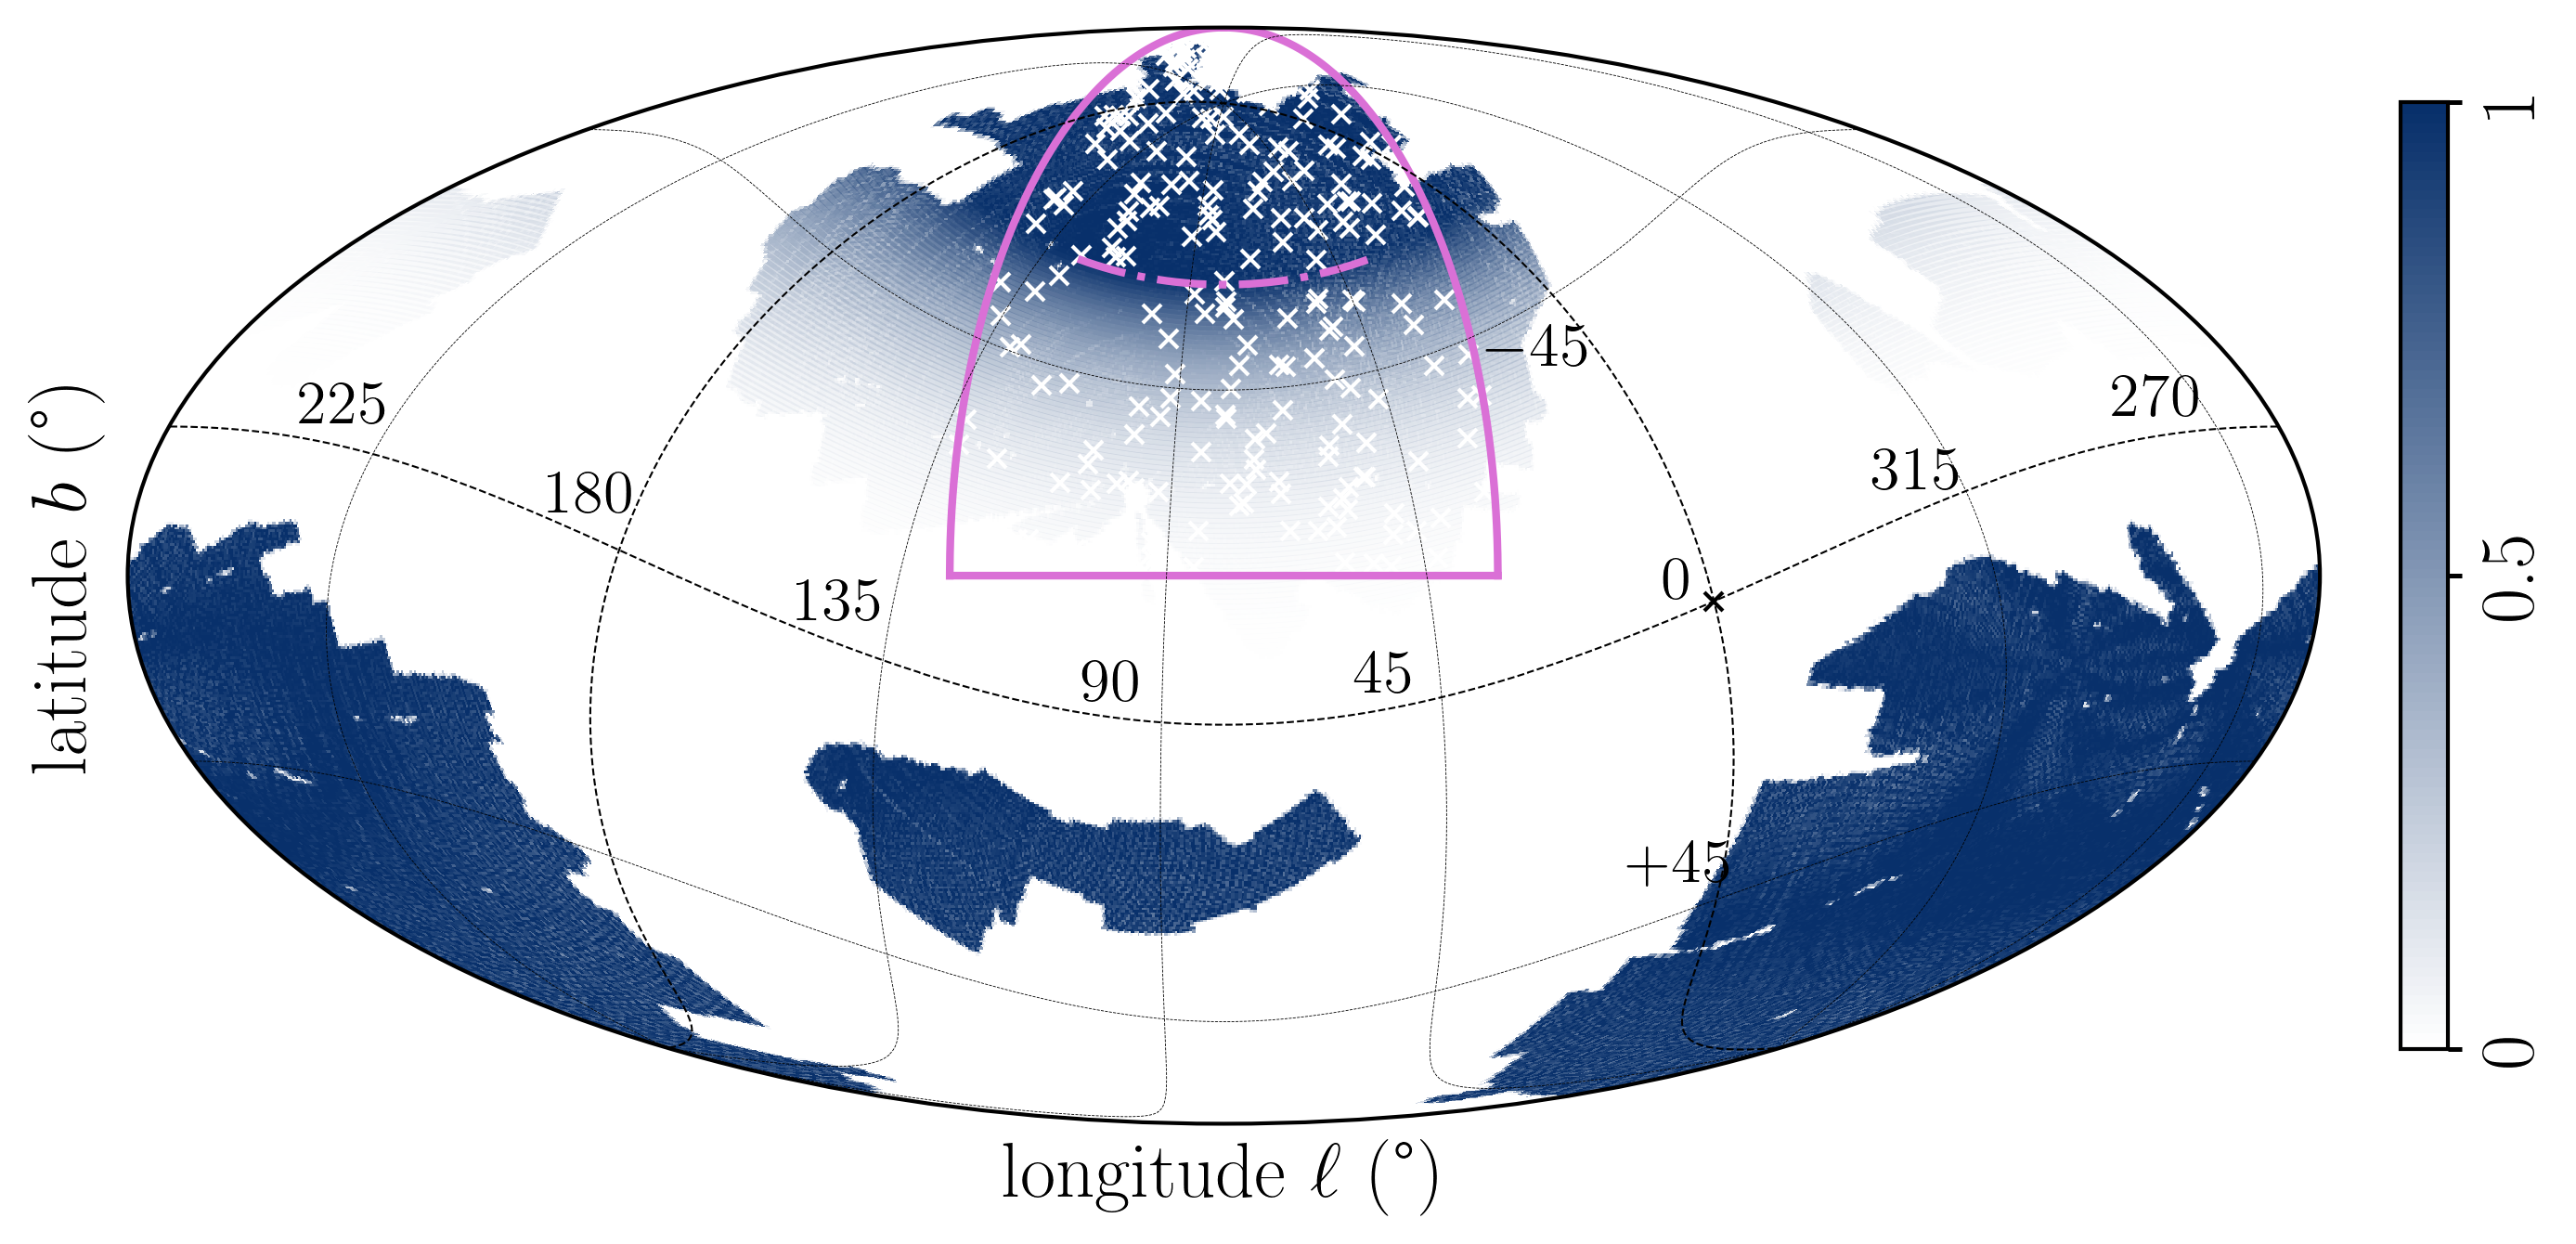

In [12]:
warnings.filterwarnings("ignore")

# Visualise the mask using a Mollweide projection
projview(
    hpx,
    coord=["C", "G"],
    projection_type="mollweide",
    rot=rotation,
    cmap=custom_cm,
    override_rot_graticule_properties={"g_linewidth": 0.2, "g_linestyle": "--", "g_color": "red"},
    graticule=False,
    xlabel=r"longitude $\ell$ (°)",
    ylabel=r"latitude $b$ (°)",
    cbar=True,
    cbar_ticks=[0, 0.5, 1],
    cb_orientation="vertical",
    fontsize={
        "xtick_label": GLOBAL_FS,
        "ytick_label": GLOBAL_FS,
        "cbar_label": GLOBAL_FS,
        "xlabel": GLOBAL_FS,
        "ylabel": GLOBAL_FS,
        "cbar_tick_label": GLOBAL_FS,
        "title": GLOBAL_FS,
    },
)

# Add markers for the centres of small holes in the rotated coordinate system
for lat, lon in zip(lats_centers_small_holes, longs_centers_small_holes):
    newprojplot(
        theta=c[0] - lat, phi=c[1] + lon, marker="x", color="white", markersize=5, linewidth=0
    )

# Draw a rotated grid of latitude lines in the observed patch
ndots = 1000
latitudes = np.ones(ndots) * np.pi / 2 - np.pi / 3
longitudes = np.linspace(
    np.pi / 4 + rotation[0] * np.pi / 180, -np.pi / 4 + rotation[0] * np.pi / 180, ndots
)
rotated_latitudes, rotated_longitudes = hp.Rotator(rot=rotation)(latitudes, longitudes)
longitudes_ext = np.linspace(
    rotation[0] * np.pi / 180 - np.pi * 0.999, rotation[0] * np.pi / 180 + np.pi * 0.999, ndots
)

# Visualise latitude bands
Nlines = int(1.5 * maxlat * 180 / np.pi)
for i in range(Nlines):
    latitudes_ext = np.ones(ndots) * np.pi / 2 - maxlat * i / (Nlines - 1)

    rotated_latitudes_ext, rotated_longitudes_ext = hp.Rotator(rot=rotation)(
        latitudes_ext, longitudes_ext
    )
    newprojplot(
        rotated_latitudes_ext,
        rotated_longitudes_ext,
        color="white",
        alpha=1 - (i / (Nlines - 1)),
        linestyle="-",
        linewidth=5,
    )

color_octant = "orchid"


# Add visual elements for the observed octant and real galactic coordinate grid
newprojplot(
    theta=line1_theta, phi=line1_phi, color="orchid", markersize=10, label="Observed octant"
)
newprojplot(theta=line2_theta, phi=line2_phi, color="orchid", markersize=10)
newprojplot(theta=line3_theta, phi=line3_phi, color="orchid", markersize=10)
newprojplot(
    rotated_latitudes,
    rotated_longitudes,
    color="orchid",
    linestyle="-.",
    linewidth=2,
    markersize=1,
)


col_real_galactic = "black"
linestyle_real_galactic = "--"

lats = np.linspace(-np.pi * 0.999, np.pi * 0.999, ndots)
ones = np.ones(ndots)
rot_lats, rot_longs = hp.Rotator(rot=rotation)(lats, 0 * ones)
newprojplot(
    rot_lats, rot_longs, color=col_real_galactic, linestyle=linestyle_real_galactic, linewidth=0.5
)
for long in [np.pi / 4, np.pi / 2, 3 * np.pi / 4]:
    longs = ones * long
    rot_lats, rot_longs = hp.Rotator(rot=rotation)(lats, longs)
    newprojplot(
        rot_lats,
        rot_longs,
        color=col_real_galactic,
        linestyle=linestyle_real_galactic,
        linewidth=0.2,
    )

longs = np.linspace(
    rotation[0] * np.pi / 180 - np.pi * 0.999, rotation[0] * np.pi / 180 + np.pi * 0.999, ndots
)
lats = np.ones(ndots) * np.pi / 2
rot_lats, rot_longs = hp.Rotator(rot=rotation)(lats, longs)
newprojplot(
    rot_lats, rot_longs, color=col_real_galactic, linestyle=linestyle_real_galactic, linewidth=0.5
)
for lat in [np.pi / 4, 3 * np.pi / 4]:
    lats = ones * lat
    rot_lats, rot_longs = hp.Rotator(rot=rotation)(lats, longs)
    newprojplot(
        rot_lats,
        rot_longs,
        color=col_real_galactic,
        linestyle=linestyle_real_galactic,
        linewidth=0.2,
    )

newprojplot(
    theta=rot_lat_origin_galactic,
    phi=rot_lon_origin_galactic,
    marker="x",
    color=col_real_galactic,
    markersize=5,
)

xx_ticks_row0 = [-2.76, -1.95, -1.23, -0.42, 0.38, 1.26, 1.88, 2.66]
yy_ticks_row0 = [2.92, 3.19, 3.53, 3.8, 3.77, 3.46, 3.12, 2.9]
ticks_labs_row0 = [r"$225$", r"$180$", r"$135$", r"$90$", r"$45$", r"$0$", r"$315$", r"$270$"]
for i in range(len(yy_ticks_row0)):
    xtick = xx_ticks_row0[i]
    ytick = yy_ticks_row0[i]
    tick_lab = ticks_labs_row0[i]
    plt.text(xtick, ytick, tick_lab, color="black", fontsize=GLOBAL_FS_TINY)

xx_ticks_col0 = [0.81, 1.39]
yy_ticks_col0 = [2.75, 4.5]
ticks_labs_col0 = [r"$-45$", r"$+45$"]
for i in range(len(yy_ticks_col0)):
    xtick = xx_ticks_col0[i]
    ytick = yy_ticks_col0[i]
    tick_lab = ticks_labs_col0[i]
    plt.text(xtick, ytick, tick_lab, color="black", fontsize=GLOBAL_FS_TINY)

plt.savefig(wd / "expl/projected_mask_horizontal.png", dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(wd / "expl/projected_mask_horizontal.pdf", dpi=300, bbox_inches="tight")
plt.show()
warnings.filterwarnings("default")

In [13]:
# Custom aperture size based on grid resolution
aperture = 2e-3 if N >= 512 else 4.5e-3 if N >= 256 else 1e-2 if N >= 128 else 5e-2

# Filename for the mask with holes
name_holes = "holes{}_{}_ext{}_mask_{}_N{}.npy".format(
    Nholes, str(round(aperture, 5)).replace(".", ""), round(maxlat * 180 / np.pi), today, N
)

# Generate or load the mask with holes
if not exists(wd / name_holes) or force:
    # Rotate the map to align with the observed patch
    rotator = hp.rotator.Rotator(rot=rotation, coord=["C", "G"], deg=True)
    hpx_rotated = rotator.rotate_map_pixel(hpx)
    lats = c[0] - grid_sph_latlon[:, :, :, 0]
    longs = c[1] + grid_sph_latlon[:, :, :, 1]
    grid_mask_holes = hp.get_interp_val(hpx_rotated, lats, longs, lonlat=False)

    # Create holes by setting values within the aperture to zero
    for lat_hole, long_hole in zip(lats_centers_small_holes, longs_centers_small_holes):
        distances = np.sqrt((lats - lat_hole) ** 2 + (longs - long_hole) ** 2)
        grid_mask_holes[distances <= aperture] = 0

    # Rotate latitudes and longitudes back to galactic coordinates
    lats_g_1d, longs_g_1d = inverse_rotation(lats.flatten(), longs.flatten())
    lats_g = lats_g_1d.reshape((N, N, N))
    longs_g = longs_g_1d.reshape((N, N, N))

    # Apply extinction near the Galactic plane
    mask = (lats_g > np.pi / 2 - maxlat) & (lats_g < np.pi / 2)
    extinction_coeff = (-lats_g[mask] + np.pi / 2) / maxlat
    grid_mask_holes[mask] *= extinction_coeff

    np.save(wd / name_holes, grid_mask_holes)
else:
    grid_mask_holes = np.load(wd / name_holes)

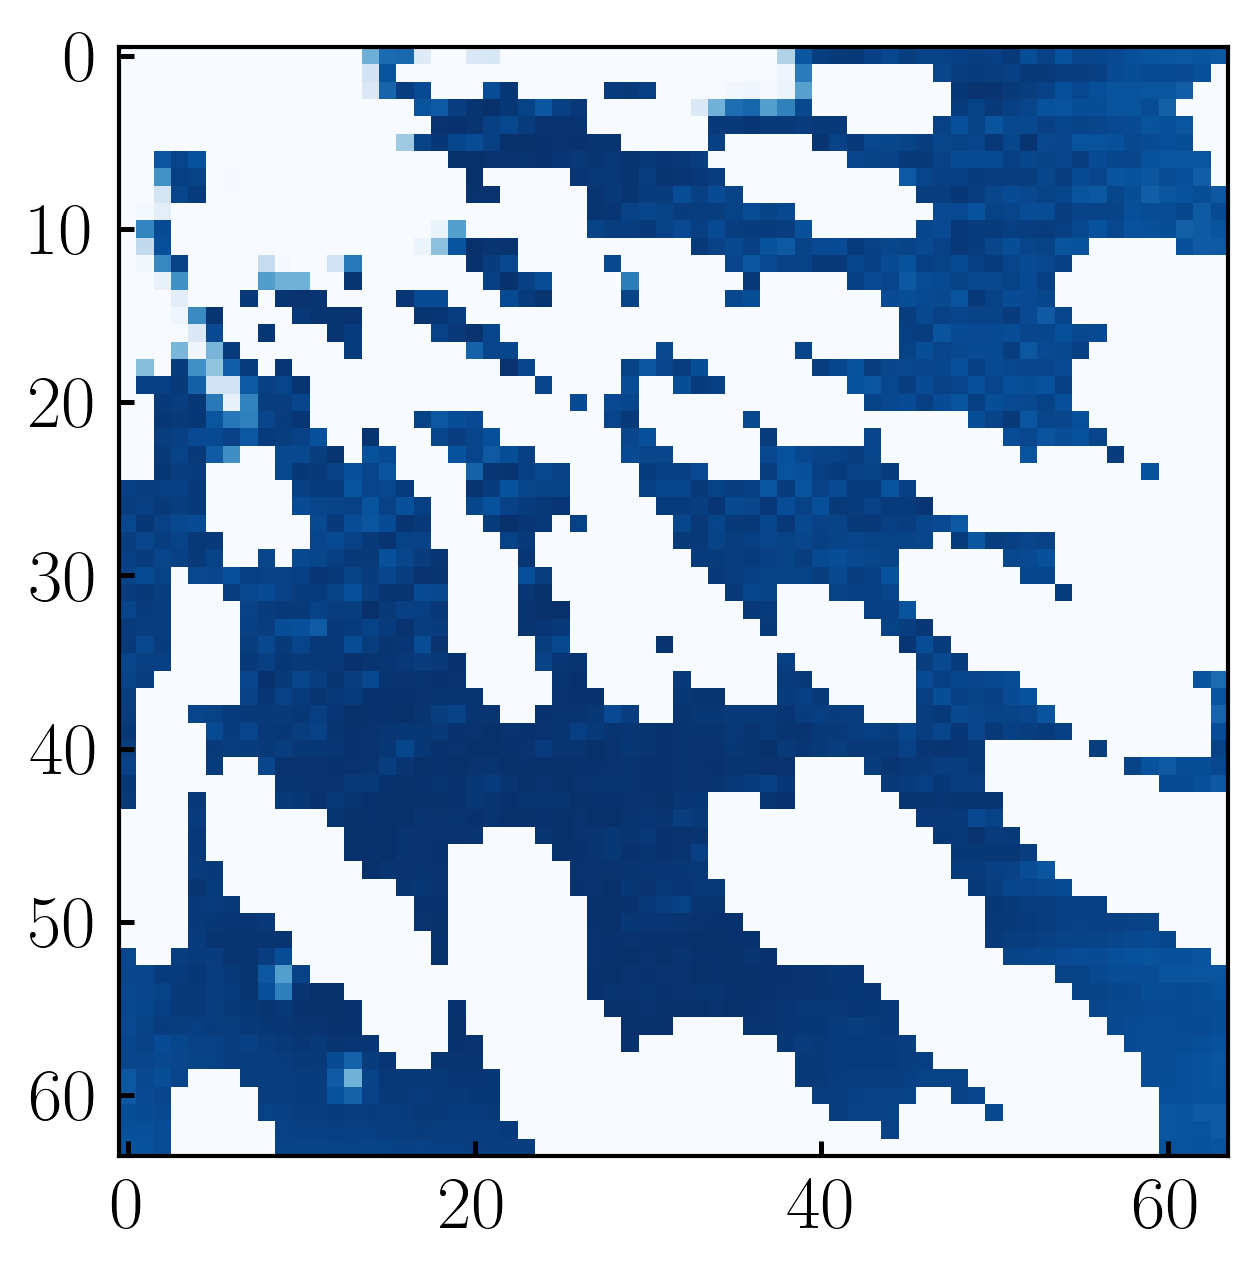

In [14]:
slice = grid_mask_holes[:,:,int(7*N//8)]
plt.imshow(slice, cmap="Blues") ; plt.show()

In [15]:
# Visualise the 3D grid mask using Plotly if enabled
if plotly:
    if N <= 128:
        fig = plotly_3d(grid_mask_holes, size=N, L=L, colormap="Blues")
    else:
        # Downsample the grid for visualisation at higher resolutions
        downsample_factor = N // 128
        downsampled_field = grid_mask_holes[
            ::downsample_factor, ::downsample_factor, ::downsample_factor
        ]
        fig = plotly_3d(downsampled_field, L=L, colormap="Blues")

    fig.show()
    # clear_large_plot(fig)  # Clear the Plotly figure to avoid memory issues